In [ ]:
!pip install --upgrade albumentations -q

import tensorflow as tf
import numpy as np
import cv2
import json
import argparse
import pickle
import os
import shutil
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Activation, UpSampling2D, Input, Concatenate, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import EfficientNetB4
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Load data from Kaggle:

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip lyft-udacity-challenge.zip

Demo:

Text(0.5, 1.0, 'Segmentation')

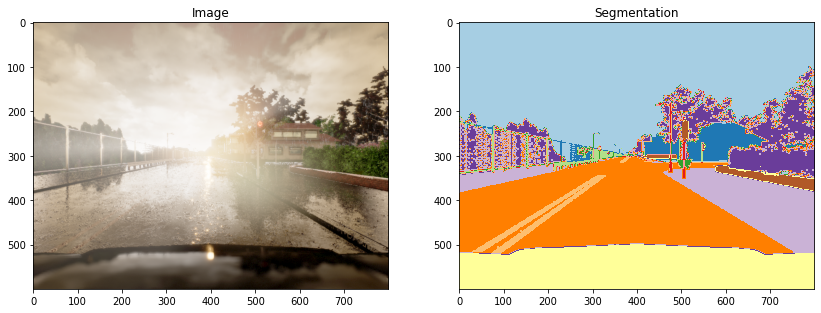

In [ ]:
image_path = 'datae/dataE/CameraRGB/'
mask_path = 'datae/dataE/CameraSeg/'

image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

import imageio

N = 10
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

Build model:

In [ ]:
image_size = 224
inputs = Input(shape=(image_size, image_size, 3), name="input_image")
encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1.0)

In [ ]:
encoder.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
def build_model_unet_mobilenet(image_size):
    alpha = 1.0
    inputs = Input(shape=(image_size, image_size, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=alpha)
    concat_layers = [
                     "input_image", 
                     "block_1_expand_relu", 
                     "block_3_expand_relu", 
                     "block_6_expand_relu"
    ]
    encoder_output = encoder.get_layer("block_13_expand_relu").output    
    filters = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(len(concat_layers)):
        ind = i + 1
        x_pair = encoder.get_layer(concat_layers[-ind]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_pair])
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(3, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
def build_model_simple_mobilenet(image_size):
    alpha = 1.0
    inputs = Input(shape=(image_size, image_size, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=alpha)
    encoder_output = encoder.get_layer("block_13_expand_relu").output    
    filters = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(4):
        ind = i + 1
        x = UpSampling2D((2, 2))(x)
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(filters[-ind], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(3, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
def build_model_unet(image_size):
    in1 = Input(shape=(image_size, image_size, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    # up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    up1 = Concatenate()([UpSampling2D((2, 2))(conv4), conv3])
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    # up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    up2 = Concatenate()([UpSampling2D((2, 2))(conv5), conv2])
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    # up3 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    up2 = Concatenate()([UpSampling2D((2, 2))(conv6), conv1])
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    return model

Generator:

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_dir, masks_dir, batch_size, image_size, augmentation, shuffle=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.augmentation = augmentation

        self.IMG_ENDING = '.png'
        self.MASK_ENDING = '.png'

        self.image_names = []
        for path in os.listdir(self.images_dir):
            self.image_names.append(path[:path.rfind('.')])

        self.samples = len(self.image_names)
        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)


    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def apply_transform(self, img, mask):
        transformed = self.augmentation(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        return img, mask


    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, self.samples)]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3), dtype='float32')
        Y = np.empty((len(take_ind), self.image_size, self.image_size, 1), dtype='float32')

        for i in range(len(take_ind)):
            img = cv2.imread(os.path.join(self.images_dir, self.image_names[take_ind[i]] + self.IMG_ENDING), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img)

            mask = cv2.imread(os.path.join(self.masks_dir, self.image_names[take_ind[i]] + self.MASK_ENDING), cv2.IMREAD_GRAYSCALE)
            # mask = mask.astype(np.float32) / 255.
            # mask[(mask != 1) & (mask != 6) & (mask != 7) & (mask != 8) & (mask != 4) & (mask != 10)] = 0
            # mask_new = np.zeros_like(mask, dtype='uint8')
            # mask_new[mask == 0] = 0
            # mask_new[mask == 1] = 1
            # mask_new[mask == 6] = 2
            # mask_new[mask == 7] = 3
            # mask_new[mask == 8] = 4
            # mask_new[mask == 4] = 5
            # mask_new[mask == 10] = 6
            # mask = mask_new

            mask[(mask != 6) & (mask != 7)] = 0
            mask_new = np.zeros_like(mask, dtype='uint8')
            mask_new[mask == 0] = 0
            # mask_new[mask == 1] = 1
            mask_new[mask == 6] = 1
            mask_new[mask == 7] = 2
            mask = mask_new

            if self.augmentation:
                img, mask = self.apply_transform(img, mask)

            X[i] = img
            Y[i] = np.expand_dims(mask, 2)

        return X, Y

Metrics:

In [ ]:
# def dice_coef(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + 1e-15) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-15)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)

# def iou_coef(gt, pred):
#     pred = tf.keras.backend.cast(tf.keras.backend.greater(pred, 0.5), dtype='float32')
#     gt = tf.keras.backend.cast(tf.keras.backend.greater(gt, 0.5), dtype='float32')
#     intersection = tf.keras.backend.sum(tf.keras.backend.sum(tf.keras.backend.squeeze(gt * pred, axis=3), axis=2), axis=1)
#     union = tf.keras.backend.sum(tf.keras.backend.sum(tf.keras.backend.squeeze(gt + pred, axis=3), axis=2), axis=1) - intersection
#     iou = tf.keras.backend.mean((intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon()))
#     return iou

def sparse_Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    pred_pixels = K.argmax(y_pred, axis=-1)
    # ok_classes = [1, 6, 7, 8, 4, 10]
    for i in range(0, nb_classes):
        # if i not in ok_classes:
        #     continue
        true_labels = K.equal(y_true[:,:,0], i)
        pred_labels = K.equal(pred_pixels, i)
        inter = tf.compat.v1.to_int32(true_labels & pred_labels)
        union = tf.compat.v1.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.compat.v1.to_int32(true_labels), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.compat.v1.debugging.is_nan(iou)
    iou = tf.compat.v1.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)

def iou_loss(y_true, y_pred):
    return 1.0 - sparse_Mean_IOU(y_true, y_pred)

def dice_coeff(y_true, y_pred):
    Ncl = y_pred.shape[-1]
    w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0,1,2))
    w = 1/(w**2+0.000001)
    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

Preprocess:

In [ ]:
TRAIN_IMAGES_DIR = 'dataA/dataA/CameraRGB/'
TRAIN_MASKS_DIR = 'dataA/dataA/CameraSeg/'
TEST_IMAGES_DIR = 'dataB/dataB/CameraRGB/'
TEST_MASKS_DIR = 'dataB/dataB/CameraSeg/'
TRAINED_MODEL_PATH = '/content/drive/My Drive/self-driving/mobilenet_unet_224.hdf5'

IMAGE_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 16
LR = 3e-4

In [ ]:
def process_img(path):
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = img_to_array(img)
    cv2.imwrite(path, img)

def process_mask(path):
    mask = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    mask = img_to_array(mask)
    mask = mask.max(axis=2)
    # mask = (mask == 7).astype('uint8') * 255
    cv2.imwrite(path, mask)

In [ ]:
for path in tqdm(os.listdir(TRAIN_IMAGES_DIR)):
    process_img(os.path.join(TRAIN_IMAGES_DIR, path))

for path in tqdm(os.listdir(TEST_IMAGES_DIR)):
    process_img(os.path.join(TEST_IMAGES_DIR, path))

for path in tqdm(os.listdir(TRAIN_MASKS_DIR)):
    process_mask(os.path.join(TRAIN_MASKS_DIR, path))

for path in tqdm(os.listdir(TEST_MASKS_DIR)):
    process_mask(os.path.join(TEST_MASKS_DIR, path))

Training:

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, 
                          scale_limit=0.1,
                          rotate_limit=(10, 10),
                          p=0.5)
], p=1)

In [ ]:
train_generator = DataGenerator(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, BATCH_SIZE, IMAGE_SIZE, augmentation=None, shuffle=True)
val_generator = DataGenerator(TEST_IMAGES_DIR, TEST_MASKS_DIR, BATCH_SIZE, IMAGE_SIZE, augmentation=None, shuffle=False)

model_simple = build_model_simple_mobilenet(IMAGE_SIZE)
# model_mobilenet_unet = build_model_unet_mobilenet(IMAGE_SIZE)

opt = tf.keras.optimizers.Nadam(LR)
metrics = [sparse_Mean_IOU, 'accuracy']
# model_simple.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=metrics)
model_simple.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=metrics)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint(TRAINED_MODEL_PATH, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
]

In [ ]:
hist_simple = model_simple.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
62/62 [==============================] - ETA: 0s - loss: 0.6523 - sparse_Mean_IOU: 0.5507 - accuracy: 0.6884
Epoch 00001: val_loss improved from inf to 0.90300, saving model to /content/drive/My Drive/self-driving/mobilenet_unet_224.hdf5
62/62 [==============================] - 18s 286ms/step - loss: 0.6523 - sparse_Mean_IOU: 0.5507 - accuracy: 0.6884 - val_loss: 0.9030 - val_sparse_Mean_IOU: 0.5390 - val_accuracy: 0.7213
Epoch 2/15
62/62 [==============================] - ETA: 0s - loss: 0.4225 - sparse_Mean_IOU: 0.6462 - accuracy: 0.7914
Epoch 00002: val_loss improved from 0.90300 to 0.64376, saving model to /content/drive/My Drive/self-driving/mobilenet_unet_224.hdf5
62/62 [==============================] - 17s 268ms/step - loss: 0.4225 - sparse_Mean_IOU: 0.6462 - accuracy: 0.7914 - val_loss: 0.6438 - val_sparse_Mean_IOU: 0.6612 - val_accuracy: 0.7820
Epoch 3/15
62/62 [==============================] - ETA: 0s - loss: 0.3547 - sparse_Mean_IOU: 0.6615 - accuracy: 0.7957
Ep

KeyboardInterrupt: ignored

In [ ]:
model = load_model('/content/drive/My Drive/self-driving/mobilenet_v2_unet_all_classes.hdf5')

Testing:

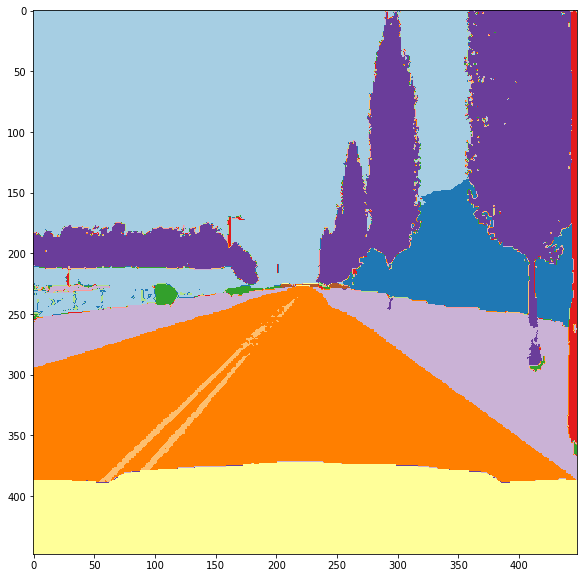

In [ ]:
# path = '/content/dataC/dataC/CameraRGB/F6-34.png'
# path = '/content/dataC/dataC/CameraRGB/02_00_064.png'
# path = '/content/dataC/dataC/CameraRGB/02_02_194.png'
# path = '/content/dataC/dataC/CameraRGB/07_00_184.png'
# path = '/content/dataC/dataC/CameraRGB/F7-94.png'


img = cv2.imread(path)
img = cv2.resize(img, (IMAGE_SIZE*2, IMAGE_SIZE*2))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = transform(image=img)['image']
pred = model.predict(np.expand_dims(preprocess_input(img), axis=0))[0]

# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 10))
# res = img + np.expand_dims(pred.argmax(axis=2)==7, 2)*255
# res = cv2.resize(res.astype('float32'), (500, 500))
# plt.imshow(res.astype('int'), cmap='Paired')
# plt.imshow((pred.argmax(axis=2)==10)>0.5)
mask = (((pred.argmax(axis=2)==0) > 0.5)*255).astype('uint8')
mask2 = (((pred.argmax(axis=2)==6) > 0.5)*255).astype('uint8')
# mask3 = (((pred.argmax(axis=2)==1) > 0.5)*255).astype('uint8')
comb = mask+ mask2*0.5
# plt.imshow(mask)
plt.imshow(pred.argmax(axis=2), cmap='Paired')
# plt.subplot(1, 2, 2)
# plt.imshow(pred.argmax(axis=2)==7)

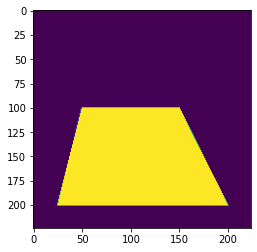

In [ ]:
a3 = np.array( [[[50,100],[150,100],[200,200], [25,200]]], dtype=np.int32 )
im = np.zeros([IMAGE_SIZE, IMAGE_SIZE],dtype=np.uint8)
polymask = cv2.fillPoly( im, a3, 1 )
plt.imshow(polymask)

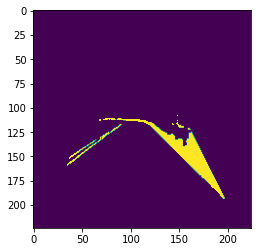

In [ ]:
plt.imshow(comb & polymask)

In [ ]:
path = '/content/datac/dataC/CameraRGB/F6-34.png'
img = cv2.imread(path)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = transform(image=img)['image']
pred = model_unet.predict(np.expand_dims(preprocess_input(img), axis=0))[0]

# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 10))
# res = img + np.expand_dims(pred.argmax(axis=2)==7, 2)*255
# res = cv2.resize(res.astype('float32'), (500, 500))
# plt.imshow(res.astype('int'), cmap='Paired')
# plt.imshow((pred.argmax(axis=2)==10)>0.5)
# mask = (((pred.argmax(axis=2)==6) > 0.5)*255).astype('uint8')
# mask2 = (((pred.argmax(axis=2)==7) > 0.5)*255).astype('uint8')
# mask3 = (((pred.argmax(axis=2)==1) > 0.5)*255).astype('uint8')
# plt.imshow(mask+ mask2*0.1 + mask3*0.2)
plt.imshow(pred.argmax(axis=2), cmap='Paired')
# plt.subplot(1, 2, 2)
# plt.imshow(pred.argmax(axis=2)==7)

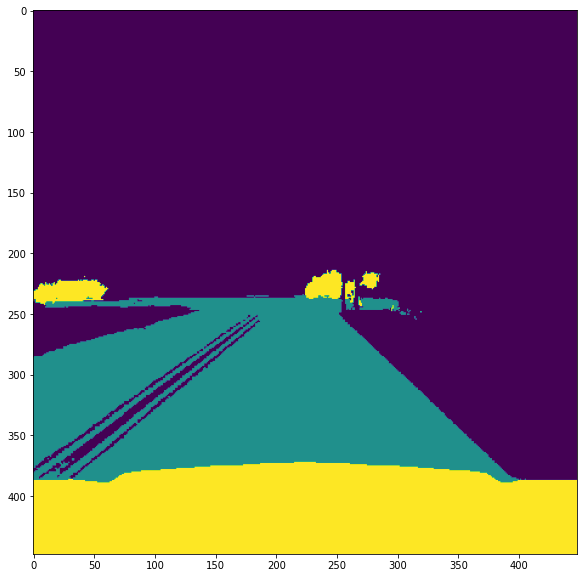

In [ ]:
path = '/content/datad/dataD/CameraRGB/02_01_097.png'
img = cv2.imread(path)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = transform(image=img)['image']
pred = model.predict(np.expand_dims(preprocess_input(img), axis=0))[0]

# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 10))
# res = img + np.expand_dims(pred.argmax(axis=2)==7, 2)*255
# res = cv2.resize(res.astype('float32'), (500, 500))
# plt.imshow(res.astype('int'), cmap='Paired')
# plt.imshow((pred.argmax(axis=2)==10)>0.5)
mask = (((pred.argmax(axis=2)==10) > 0.5)*255).astype('uint8')
mask2 = (((pred.argmax(axis=2)==7) > 0.5)*255).astype('uint8')
plt.imshow(mask+ 0.5*mask2)
# plt.imshow(pred.argmax(axis=2))
# plt.subplot(1, 2, 2)
# plt.imshow(pred.argmax(axis=2)==7)

In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# !wget https://drive.google.com/drive/folders/?usp=sharing
json_import = drive.CreateFile({'id':'1mq5h6VUzDFxC-ny1MJ8qvCEzxq57DDAg'})
json_import.GetContentFile('img.jpg')

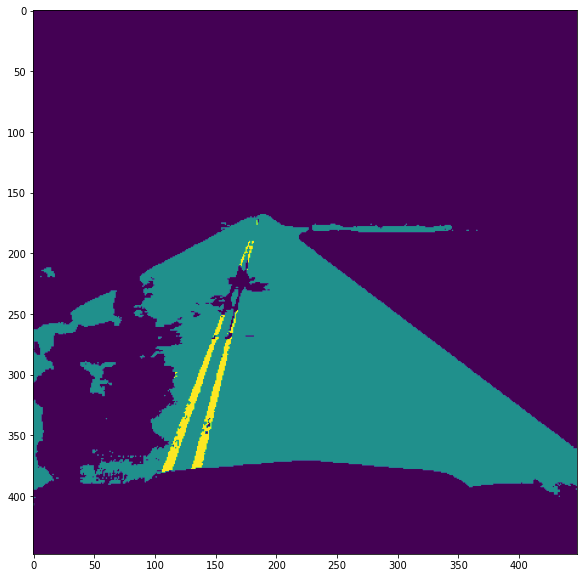

In [ ]:
path = '/content/img.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (448, 448))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = transform(image=img)['image']
pred = model.predict(np.expand_dims(preprocess_input(img), axis=0))[0]

# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 10))
# res = img + np.expand_dims(pred.argmax(axis=2)==7, 2)*255
# res = cv2.resize(res.astype('float32'), (500, 500))
# plt.imshow(res.astype('int'), cmap='Paired')
# plt.imshow((pred.argmax(axis=2)==10)>0.5)
mask = (((pred.argmax(axis=2)==6) > 0.5)*255).astype('uint8')
mask2 = (((pred.argmax(axis=2)==7) > 0.5)*255).astype('uint8')
plt.imshow(mask+ 0.5*mask2)
# plt.imshow(pred.argmax(axis=2))
# plt.subplot(1, 2, 2)
# plt.imshow(pred.argmax(axis=2)==7)

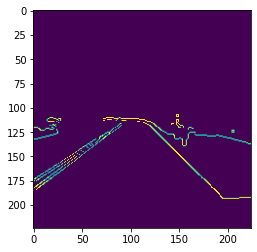

In [ ]:
edges = cv2.Canny(comb,100,200)
# edges = cv2.bitwise_not(edges)
# cv2_imshow(edges)
plt.imshow(edges)

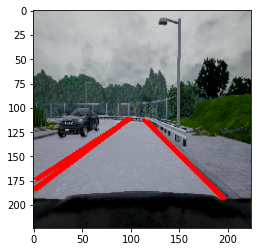

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, maxLineGap=100)
dmy = img.copy()

# Plot detected lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    if abs(y1-y2) / abs(x2-x1) < 0.2:
        # print(abs(x1-x2), abs(y1-y2))
        continue
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(dmy)

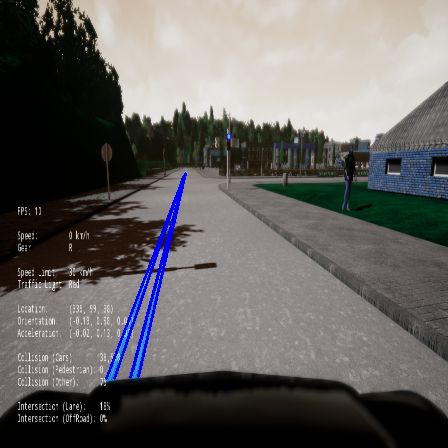

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, maxLineGap=100)
dmy = img.copy()

# Plot detected lines

for line in lines:
    x1, y1, x2, y2 = line[0]
    if abs(y1-y2) / abs(x2-x1) < 0.1:
        # print(abs(x1-x2), abs(y1-y2))
        continue
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 2)

cv2_imshow(dmy)

In [ ]:
mask = (((pred.argmax(axis=2)==10) > 0.5)*255).astype('uint8')

des = cv2.bitwise_not(mask)
contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv2.drawContours(des,[cnt],0,255,-1)

gray = cv2.bitwise_not(des)

In [ ]:
def fillHole(im_in):
	im_floodfill = im_in.copy()

	# Mask used to flood filling.
	# Notice the size needs to be 2 pixels than the image.
	h, w = im_in.shape[:2]
	mask = np.zeros((h+2, w+2), np.uint8)

	# Floodfill from point (0, 0)
	cv2.floodFill(im_floodfill, mask, (0,0), 255);

	# Invert floodfilled image
	im_floodfill_inv = cv2.bitwise_not(im_floodfill)

	# Combine the two images to get the foreground.
	im_out = im_in | im_floodfill_inv

	return im_out

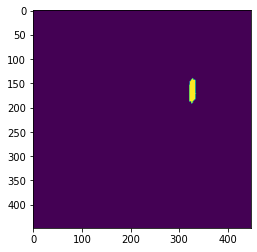

In [ ]:
mask = (((pred.argmax(axis=2)==12) > 0.5)*255).astype('uint8')
# mask = fillHole(mask)
plt.imshow(mask)

In [ ]:
thresh = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)[1]
# find contours in thresholded image, then grab the largest
# one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
a = cv2.drawContours(mask, [c], -1, (0, 255, 0), 2)
print('ok')
from google.colab.patches import cv2_imshow
a[a == 255] = 1
cv2_imshow(img * np.expand_dims(a, 2))

ValueError: ignored

x:323, y:144, width:9, height:43


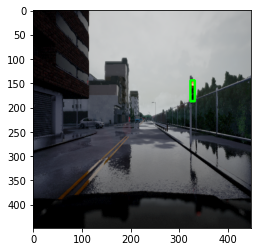

In [ ]:
x, y, w, h = cv2.boundingRect(mask)
rect1 = cv2.rectangle(img.copy(),(x,y),(x+w,y+h),(0,255,0),3) # not copying here will throw an error
print("x:{0}, y:{1}, width:{2}, height:{3}".format(x, y, w, h))
plt.imshow(rect1)
plt.show()

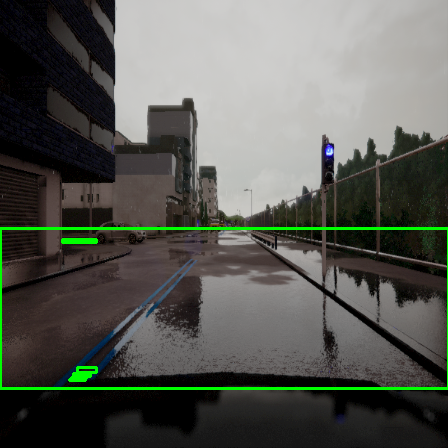

In [ ]:
import cv2

# lemBGR = cv2.imread("lem.png")
# lem = cv2.cvtColor(lemBGR,cv2.COLOR_BGR2GRAY)
lem = mask
# Dilate the image in order to close any external contour of the leming
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
lem = cv2.dilate(lem,kernel)

# Identify holes in the leming contour
# This could be done by iterative morphological operations,
# but this is not directly implemented in OpenCV
contour,hier = cv2.findContours(lem.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
# And fill them
for c,h in zip(contour, hier[0]):
    if h[3]!=-1:
        cv2.drawContours(lem,[c],0,255,-1)

# Now bring the leming back to its original size
lem = cv2.erode(lem,kernel)

# Remove the cord by wiping-out all vertical lines
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15,1))
#lem = cv2.erode(lem,kernel) # first wipe-out
#lem = cv2.dilate(lem,kernel) # then bring back to original size
# erode and then dilate is the same as opening
lem = cv2.morphologyEx(lem,cv2.MORPH_OPEN,kernel)

# Find the contour of the leming
contour,_ = cv2.findContours(lem.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# And draw it on the original image
for c in contour:
    # enter your filtering here
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

# Display the result
cv2_imshow(img)


In [ ]:
filenames = [os.path.join(TRAIN_IMAGES_DIR, path) for path in os.listdir(TRAIN_IMAGES_DIR)]

In [ ]:
import imageio
images = []
for filename in tqdm(filenames):
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)

In [ ]:
import imageio
with imageio.get_writer('/movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
from IPython.display import Image
Image(open('movie.gif','rb').read())

In [ ]:
with open('movie.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

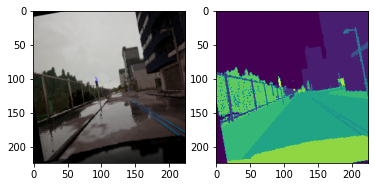

In [ ]:
path = '/content/dataa/dataA/CameraRGB/02_00_011.png'
img = cv2.imread(path)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
# img = preprocess_input(img)
# pred = model.predict(np.expand_dims(img, axis=0))[0]
mask = cv2.imread('/content/dataa/dataA/CameraSeg/02_00_011.png')
mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
tr = transform(image=img, mask=mask)
plt.imshow(tr['image'])
plt.subplot(1, 2, 2)
plt.imshow(tr['mask'][:, :, 0])

Other:

In [ ]:
# shutil.copy('/content/segmentation_model.hdf5', '/content/drive/My Drive/CV/birds segmentation/model_6_89.hdf5')
# shutil.copy('/content/drive/My Drive/CV/birds segmentation/model_4_86.hdf5', '/content/segmentation_model.hdf5')
shutil.copy(TRAINED_MODEL_PATH, '/content/segmentation_model.hdf5')
# shutil.copy('/content/segmentation_model_1.hdf5', '/content/segmentation_model.hdf5')
model.save('/content/segmentation_model.hdf5')
# model.save('segmentation_model.hdf5')
model = load_model('segmentation_model.hdf5', compile=False)
model.save('segmentation_model.hdf5')

Video from Kaggle:

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)
    
    #cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    #print(poly_vertices)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10)
    return lines_edges
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [ ]:
model = load_model('/content/drive/My Drive/self-driving/mobilenet_v2_unet_all_classes.hdf5')

In [ ]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    # output = masked_img
    return output

# Lane finding Pipeline
def lane_finding_pipeline_model(image):
    
    #Grayscale
    # gray_img = grayscale(image)
    # #Gaussian Smoothing
    # smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    # #Canny Edge Detection
    # canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    # #Masked Image Within a Polygon
    # masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    # #Hough Transform Lines
    # houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    # #Draw lines on edges
    # output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    image = cv2.resize(image, (448, 448))

    pred = model.predict(np.expand_dims(preprocess_input(image), axis=0))[0]
    mask = np.expand_dims((((pred.argmax(axis=2)==10) > 0.5)*255).astype('uint8'), 2)
    mask2 = np.expand_dims((((pred.argmax(axis=2)==7) > 0.5)*255).astype('uint8'), 2)

    res = image + mask + mask2 * 0.5
    # res = cv2.resize(res.astype('float32'), (500, 500))

    # edges = cv2.Canny(mask,100,200)

    # lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, maxLineGap=100)
    # dmy = image.copy()

    # # Plot detected lines

    # for line in lines:
    #     x1, y1, x2, y2 = line[0]
    #     if abs(y1-y2) / abs(x2-x1) < 0.1:
    #         # print(abs(x1-x2), abs(y1-y2))
    #         continue
    #     cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 2)
    # output = masked_img
    return res

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/jaipurHighway.mp4").subclip(50,60)
clip1 = VideoFileClip("/content/testsolidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline_model) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight.mp4
[MoviePy] Writing video solidWhiteRight.mp4


100%|█████████▉| 221/222 [02:16<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight.mp4 

CPU times: user 3min 52s, sys: 4.48 s, total: 3min 57s
Wall time: 2min 16s
